# Yolo V3 - Pytorch

En este notebook vamos a usar Yolo V3 implementado en Pytorch para predecir objetos en una imágen.

In [33]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
import argparse
import os 
import os.path as osp
from darknet import *
import pickle as pkl
import pandas as pd
import random
import math
import random
import matplotlib.pyplot as plt

Yolo V3 ha sido entrenada con el dataset COCO, que tiene 80 clases. 

In [34]:
num_classes = 80    
classes = fp = open("coco.names", "r")
classes = fp.read().split("\n")[:-1]

Ahora seteamos los parámetros de la red y la cargamos.

In [35]:
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
resolution = 416

model = Darknet("yolov3.cfg")
model.load_weights("yolov3.weights")

model.net_info["height"] = resolution
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): Batch

Cargamos una imágen.

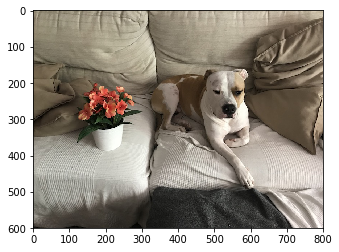

In [36]:
image = "imgs/caprica.JPG"

path = osp.join(osp.realpath('.'), image)
img = cv2.imread(path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Preparamos la imágen para alimentar la red.

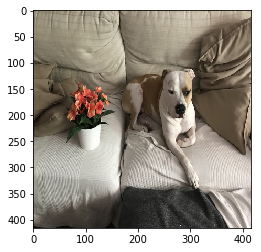

In [37]:
img_dim = (img.shape[1], img.shape[0])
img_dim = torch.FloatTensor(img_dim).repeat(1,2)

data = cv2.resize(img, (inp_dim,inp_dim))
plt.imshow(cv2.cvtColor(data, cv2.COLOR_BGR2RGB))
plt.show()
data = data[:,:,::-1].transpose((2,0,1)).copy()
data = torch.from_numpy(data).float().div(255.0).unsqueeze(0)

Forward del modelo. Pasamos la predicción por el algoritmo de NMS y obtenemos el número de objetos detectados.

In [38]:
prediction = model(Variable(data, volatile = True), False)
print("Tamaño de la predicción (antes de NMS): ",prediction.shape)
prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)
output = prediction  
print("Tamaño de la predicción (tras NMS): ",output.shape)

/Users/juansensio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.
/Users/juansensio/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Tamaño de la predicción (antes de NMS):  torch.Size([1, 10647, 85])
Tamaño de la predicción (tras NMS):  torch.Size([3, 8])


Por último, usaremos los valores de las cajas y etiquetas para dibujarlas sobre la imágen original.

In [39]:
objs = [classes[int(x[-1])] for x in output]
print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
print("----------------------------------------------------------")

scaling_factor = torch.min(inp_dim/img_dim,1)[0].view(-1,1)

output[:,[1,3]] -= (inp_dim - scaling_factor*img_dim[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*img_dim[:,1].view(-1,1))/2
    
output[:,1:5] /= scaling_factor
    
for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, img_dim[0,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, img_dim[0,1])
    
colors = pkl.load(open("pallete", "rb"))
        
for x in output:
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = colors[math.floor(random.random()*len(colors))]
    cv2.rectangle(img, c1, c2, color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);

Objects Detected:    dog sofa pottedplant
----------------------------------------------------------


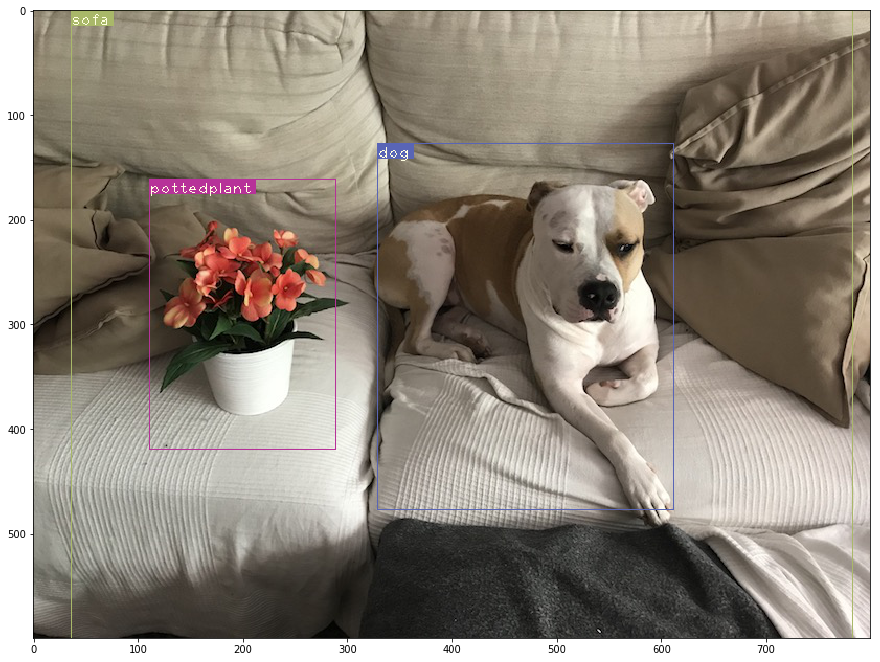

In [41]:
cv2.imwrite("det/caprica.JPG",img)
plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()